In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import to_rgba

# Set the display width to a larger value (e.g., 200 characters)
pd.set_option('display.width', 200)

# Allow each column to display more content without truncation
pd.set_option('colheader_justify','center','display.max_colwidth', None)

# 1.9.25 : after reviewing some of the general sentiment of ecology, it seems there is a popular index (the 
# Shannon index) that is used for biodiversity (interestingly a derivative of an entropy equation). Scrapping
# previous work in favour of pursuing this. Original work saved in separate python file

In [2]:
# Data to be worked with
obs_df = pd.read_csv("observations.csv")
spec_df = pd.read_csv("species_info.csv")

#  double-check/clean
def initial_check(df):
    print(df.count())
    print(df.head(3))
    print(df.describe())
    print(df.dtypes)
    return
obs_df = obs_df.drop_duplicates()
spec_df = spec_df.drop_duplicates()
# merge dataframes into one and reset the index
merged = pd.merge(obs_df, spec_df[['scientific_name','category','conservation_status']], on='scientific_name').sort_values(by='category', ascending=True).reset_index().drop(columns='index')

# easier to reference park list get rid of all ' National Park' to make it look slightly better for charts. Later dropped need for parks with exploration of data
merged['park_name'] = merged['park_name'].str.replace('National Park', '').str.strip()
merged = merged.drop_duplicates()
park_l = merged.park_name.unique()
print(merged.head())

         scientific_name         park_name    observations  category  conservation_status
0     Gastrophryne carolinensis  Yellowstone       235      Amphibian          NaN       
1  Desmognathus quadramaculatus  Yellowstone       255      Amphibian          NaN       
2       Batrachoseps diabolicus     Yosemite       155      Amphibian          NaN       
3       Batrachoseps diabolicus        Bryce        80      Amphibian          NaN       
4       Batrachoseps diabolicus  Yellowstone       282      Amphibian          NaN       


In [3]:
index_df = merged.groupby(['park_name','category']).agg(
    observation_sum = ('observations','sum'), conserv_stat_count = ('conservation_status','count'), unique_spec = ('scientific_name','nunique')).reset_index()
total_observations_per_park = {}
for x in park_l:
    total_observations_per_park[x] = index_df[index_df.park_name == x].observation_sum.sum()
park_map = index_df['park_name'].map(total_observations_per_park)
index_df['pop_proportion'] = index_df['observation_sum'] / park_map
index_df['weights'] = (index_df['observation_sum'] * index_df['pop_proportion'])

test = index_df[index_df.park_name == 'Bryce']

In [4]:
# thank you ChatGPT for helping decipher the shannon diversity index (entropy? Since, if I'm reading correctly, that was the first application) formula

# It would be at this point, I'd be trying to get a lot more feedback from anyone familiar with the science in accurate calculation inconjunction with what I could
# dig up from the internet. Collaboration is key

# Define q
q = 1  #from what I read 1 is appropriate for shannon's formula

# Function to calculate diversity for a group (or the whole dataset if no grouping)
def calculate_diversity(df, q):
    if q == 1:
        # Handle the special case for q=1 (Shannon entropy)
        diversity = (-df['pop_proportion'] * df['pop_proportion'].apply(lambda x: 0 if x == 0 else np.log(x))).sum()
        return round(np.exp(diversity),2)
    else:
        # General formula
        diversity = (df['pop_proportion']**q).sum()**(1 / (1 - q))
        return round(diversity,2)

# Calculate diversity index for the whole dataset
park_indices = {}
for x in list(index_df.park_name.unique()):
    temp = index_df[index_df.park_name == x]
    div_index = calculate_diversity(temp, q)
    park_indices[x] = div_index
park_indices_table = pd.DataFrame(park_indices, index=["Shannon Diversity Index"])
print(park_indices_table)

                         Bryce  Great Smoky Mountains  Yellowstone  Yosemite
Shannon Diversity Index  2.46           2.44              2.45        2.45  


In [5]:
# rabbit hole number 5 in the search for data that best represents a science I don't know well: break down the index by taxonomic category
cat_l = list(index_df.category.unique())
park_cat_index_dict = {}
for x in park_l:
    temp = []
    for y in cat_l:
        temp.append(calculate_diversity(index_df[(index_df.park_name == x)&(index_df.category == y)],q))
    park_cat_index_dict[x] = temp

park_cat_index_dict['category'] = cat_l
park_cat_index_df = pd.DataFrame(park_cat_index_dict)
park_cat_index_df = park_cat_index_df[['category','Bryce','Great Smoky Mountains','Yellowstone','Yosemite']]

park_cat_index_df = park_cat_index_df.sort_values(by='Bryce').reset_index().drop(columns='index')

temp = []
for a in range(7):
    temp.append(np.average(list(park_cat_index_df.T[a][1:])))
for x in park_cat_index_df.keys()[1:]:
    park_cat_index_df[x] = [round(y,3) for y in park_cat_index_df[x]]

In [6]:
# Function created with the help of Chat GPT
def create_banded_table_with_title(dataframe, title, x, y, z):
    fig, ax = plt.subplots(figsize=(x, y))
    ax.axis("tight")
    ax.axis("off")
    
    # Banded row colors (shades of green)
    row_colors = [to_rgba("lightgreen", 0.5), to_rgba("white", 1.0)]
    cell_colors = [
        [row_colors[i % 2] for _ in range(len(dataframe.columns))]
        for i in range(len(dataframe) + 1)  # Add 1 for the header row
    ]
    
    # Create the table
    table = ax.table(
        cellText=[dataframe.columns.tolist()] + dataframe.values.tolist(),
        cellColours=cell_colors,
        loc="center",
    )
    
    # Style the header row
    for key, cell in table.get_celld().items():
        if key[0] == 0:  # Header row
            cell.set_text_props(weight="bold", color="white", fontsize = z)
            cell.set_facecolor("darkgreen")
        cell.set_edgecolor("gray")
    
    # Add a title
    ax.set_title(title, fontsize=16, fontweight="bold", color="darkgreen", pad = 1)

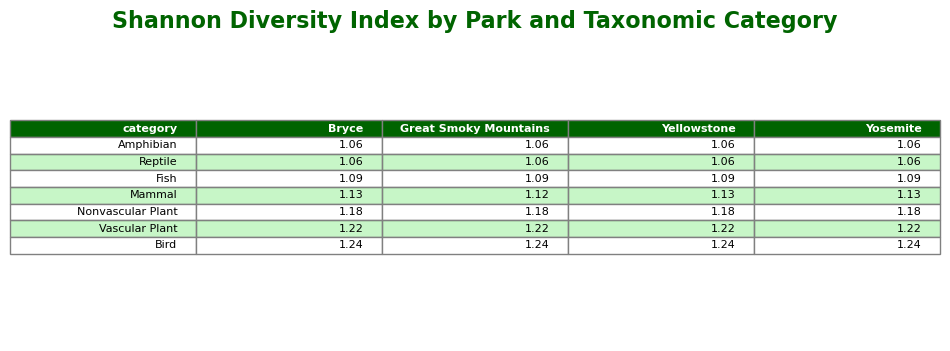

<Figure size 640x480 with 0 Axes>

In [7]:
create_banded_table_with_title(park_cat_index_df.reset_index().drop(columns='index'),"Shannon Diversity Index by Park and Taxonomic Category", 12, 4, 10)
plt.savefig("SDIbPTC.jpg")
plt.show()
plt.clf()

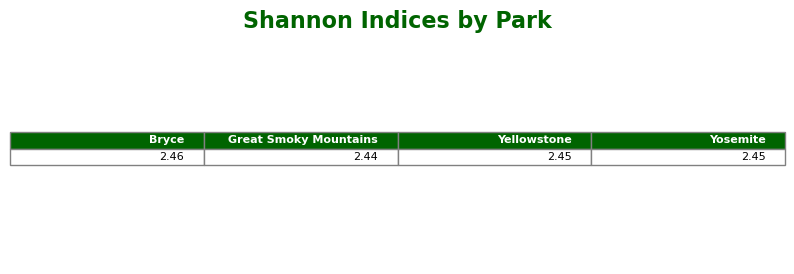

<Figure size 640x480 with 0 Axes>

In [8]:
create_banded_table_with_title(park_indices_table, "Shannon Indices by Park", 10, 3, 10)
plt.savefig("Park_Indices.jpg")
plt.show()
plt.clf()

In [9]:
print(merged.scientific_name.nunique())
for x in merged.park_name.unique():
    print(merged[merged.park_name == x].scientific_name.nunique())

5541
5541
5541
5541
5541


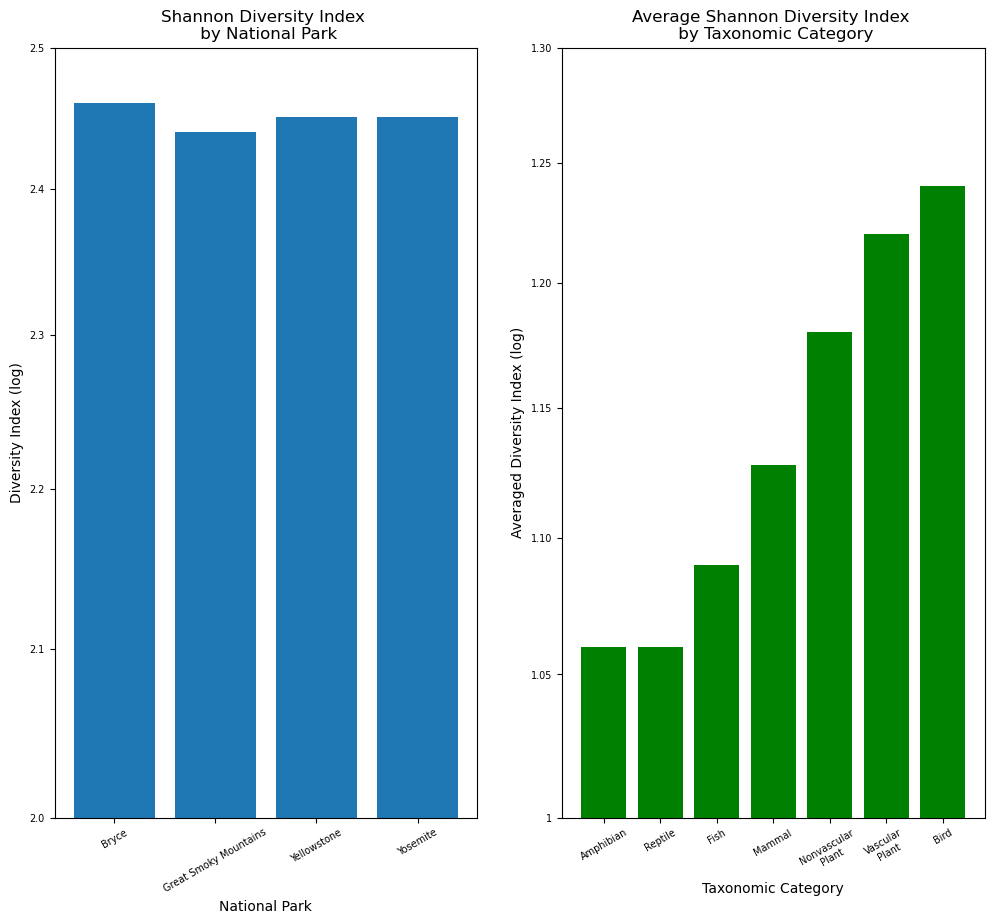

<Figure size 640x480 with 0 Axes>

In [10]:
# graphs
fig, axs = plt.subplots(1, 2, figsize=(12, 10))
ax = plt.subplot(1,2,1)
plt.bar(range(len(park_indices)),[x*100 for x in list(park_indices.values())])
ax.set_yscale('log')
ax.set_yticks(range(200, 251, 10))
ax.set_yticklabels(['2.0','2.1','2.2','2.3','2.4','2.5'], fontsize = 7)
ax.set_xticks(range(len(list(park_indices.keys()))))
ax.set_xticklabels(list(park_indices.keys()),rotation = 30, fontsize = 7)
plt.ylabel('Diversity Index (log)')
plt.xlabel('National Park')
plt.title('Shannon Diversity Index \n by National Park')

ax1 = plt.subplot(1,2,2)
plt.bar(range(len(temp)),[x*100 for x in temp], color='green')
ax1.set_yscale('log')
ax1.set_yticks(range(100,131,5))
ax1.set_yticklabels(['1','1.05','1.10','1.15','1.20','1.25','1.30'], fontsize = 7)
ax1.set_xticks(range(len(list(park_cat_index_df['category']))))
ax1.set_xticklabels([x.replace(' ', '\n') for x in list(park_cat_index_df['category'])],rotation = 30, fontsize = 7)
plt.xlabel('Taxonomic Category')
plt.ylabel('Averaged Diversity Index (log)')
plt.title('Average Shannon Diversity Index \n by Taxonomic Category')

plt.savefig("Diversity_Index_Park_Cat.jpg")
plt.show()
plt.clf()